In [25]:
import os
import subprocess

import math
from pathlib import Path
from tqdm.auto import tqdm
from multiprocessing import Pool

from osgeo import gdal
import geopandas as gpd
import pandas as pd

import numpy as np
from shapely import geometry

In [26]:
tile_size_px = [1000,1000] #x,y
tile_oxerlap_px = 150

    
output_folder = '/mnt/2TB Working 2/Projects/Ranglands ML/La grange test area/test tiles'
geotiff_folder = '/mnt/2TB Working 2/Projects/Ranglands ML/La grange test area/Test Vivid tiles'
    
input_file_ext = '.tif'
output_compression = 'JPEG'

In [27]:
output_folder

'/mnt/2TB Working 2/Projects/Ranglands ML/La grange test area/test tiles'

In [28]:
# search folder and all sub folders for 'input_file_ext' files
geo_tiff_list = []
for root, dirs, files in os.walk(output_folder):
    for file in files:
        if file.endswith(input_file_ext):
            geo_tiff_list.append(os.path.join(root, file))
            
print('We found ',len(geo_tiff_list),input_file_ext,'files')

We found  182943 .tif files


In [29]:
# if you want to filter our input raster use this
# polygons = gpd.read_file('/media/nick/2TB Working 2/Image sets/VIVID South West polygons.gpkg')
# polygons = gpd.read_file('/mnt/2TB Working 2/Projects/Nulla ML test/image classification/full preds/vivid tiles within.gpkg')

# polygons

In [30]:
# valid_names = set(polygons.tile.tolist())
# short_list = []
# for tif in geo_tiff_list:
#     file_name = os.path.basename(tif).replace('.tif','')
    
#     if file_name in valid_names:
#         short_list.append(tif)
        
# geo_tiff_list = short_list
# len(geo_tiff_list)    

In [31]:
def get_bounds(tif_path):
#     open file
    data = gdal.Open(tif_path)
#     grab bounds
    geoTransform = data.GetGeoTransform()
    left = geoTransform[0]
    top = geoTransform[3]
    right = left + geoTransform[1] * data.RasterXSize
    bottom = top + geoTransform[5] * data.RasterYSize
    geo_tiff_bounds_dict = {'top':top,'left':left,'bottom':bottom,'right':right,'tif_path':tif_path}
    return geo_tiff_bounds_dict

In [32]:
geo_tiff_bounds = get_bounds(geo_tiff_list[0])
geo_tiff_bounds

{'top': -17.897491455078125,
 'left': 122.33367919921875,
 'bottom': -17.901979334214154,
 'right': 122.33816707835479,
 'tif_path': '/mnt/2TB Working 2/Projects/Ranglands ML/La grange test area/test tiles/245/245_366.tif'}

In [33]:
# use multiprocessing to extract raster bounds
# interesting when using a small number of geotiffs its is slightly quicker to just run this as a loop
# however once you get over a 100 or so this method is much quicker
with Pool() as pool:
    geo_tiff_bounds = list(tqdm(pool.imap(get_bounds, geo_tiff_list), total=len(geo_tiff_list)))

# make new array with only bounds 
pure_bounds = []
for geo_tif_bounds in geo_tiff_bounds:
    pure_bounds.append([geo_tif_bounds['top'],geo_tif_bounds['left'],geo_tif_bounds['bottom'],geo_tif_bounds['right']])
# convert into numpy array
pure_bounds_np = np.array(pure_bounds)
# # grab max extents
bound_y_max = float(pure_bounds_np[:,0].max()) #top
bound_x_min = float(pure_bounds_np[:,1].min()) #left
bound_y_min = float(pure_bounds_np[:,2].min()) #bottom
bound_x_max = float(pure_bounds_np[:,3].max()) #right

  0%|          | 0/182943 [00:00<?, ?it/s]

In [34]:
print('top',bound_y_max,'left',bound_x_min)

top -16.962890625 left 120.9375


In [35]:
# open one image to get the pixel size
test_raster = gdal.Open(geo_tiff_list[0])
test_raster_gt =test_raster.GetGeoTransform()
pixel_size_x = test_raster_gt[1]
pixel_size_y = test_raster_gt[5]
print(pixel_size_x,pixel_size_y)

4.487879136029412e-06 -4.487879136029412e-06


In [36]:
# calculate the geographical distance in each direction each tile must be from the last tile
x_move = pixel_size_x*(tile_size_px[0]-tile_oxerlap_px)
y_move = pixel_size_y*(tile_size_px[1]-tile_oxerlap_px)

# calculate the geographical size of each tile
x_tile_size = pixel_size_x*tile_size_px[0]
y_tile_size = pixel_size_y*tile_size_px[1]
print(x_move,y_move)

0.003814697265625 -0.003814697265625


In [37]:
# calculate the number of cols so we can avoid using while loops
number_of_cols = math.ceil(abs((bound_x_max-bound_x_min)/x_move))
number_of_cols

554

In [38]:
# calculate the number of rows so we can avoid using while loops
number_of_rows = math.ceil(abs((bound_y_max-bound_y_min)/y_move))
number_of_rows

808

In [39]:
# will return a list of geotiffs which intersect 
def intersect_tile_with_geotiffs(tile_dict,geo_tiff_bounds):
#     loop over each geotiff
    intersecting_geotiffs = set()
    
    for geo_bounds in geo_tiff_bounds:
#         check is tile top or bottom is inside geotiff
        if (geo_bounds['top'] > tile_dict['top'] > geo_bounds['bottom'] or 
            geo_bounds['top'] > tile_dict['bottom'] > geo_bounds['bottom']):
#         check if left or right are inside a geotiff
            if geo_bounds['right'] > tile_dict['left'] > geo_bounds['left']:
                intersecting_geotiffs.add(geo_bounds['tif_path'])
            if geo_bounds['right'] > tile_dict['right'] > geo_bounds['left']:
                intersecting_geotiffs.add(geo_bounds['tif_path'])
    return intersecting_geotiffs

In [48]:
# will take tile bounds and only export them if they fall within a geotiff
# this is called row by row by pool below
def make_polygons(row):
    tile_polygon_list = []
    tile_top = bound_y_max + y_move*row
    tile_bottom = tile_top + y_tile_size
    tile_left = bound_x_min

    for col in tqdm(range(0,number_of_cols),total = number_of_cols):
        tile_left = bound_x_min + col*x_move
        tile_right = tile_left + x_tile_size
        tile_dict = {'top':tile_top,'left':tile_left,'bottom':tile_bottom,'right':tile_right}
        tile_list = np.array([tile_top,tile_left,tile_bottom,tile_right])
#         check if valid tile
        intersect = intersect_tile_with_geotiffs(tile_dict,geo_tiff_bounds)
        raster_name = str(row)+'_'+str(col)+'.tif'
        if len(intersect) > 0:
            polygon = {'geometry':geometry.Polygon([[tile_left, tile_top], [tile_right, tile_top], [tile_right, tile_bottom], [tile_left, tile_bottom]]),
                      'intersect':intersect, 'row':row, 'col':col, 'name':raster_name}
            tile_polygon_list.append(polygon)
    return tile_polygon_list


In [51]:
# %%time
#tile_polygon_list = []
#for row in tqdm(range(0,number_of_rows)):
#    tile_polygon_list.append(make_polygons(row))
#    break

In [44]:
%%time
# multiprocess making polygons
with Pool() as pool:
#     tile_polygon_list = pool.map(make_polygons, range(0,number_of_rows))
    tile_polygon_list = list(tqdm(pool.imap(make_polygons, range(0,number_of_rows)), total=len(range(0,number_of_rows))))

# this is returned as a list of list so it must be flattened
tile_polygon_list = list(np.concatenate(tile_polygon_list).ravel())

  0%|          | 0/808 [00:00<?, ?it/s]

Process ForkPoolWorker-127:
Process ForkPoolWorker-120:
Process ForkPoolWorker-119:
Process ForkPoolWorker-136:
Process ForkPoolWorker-114:
Process ForkPoolWorker-113:
Process ForkPoolWorker-123:
Process ForkPoolWorker-110:
Process ForkPoolWorker-124:
Process ForkPoolWorker-126:
Process ForkPoolWorker-128:
Process ForkPoolWorker-139:
Process ForkPoolWorker-111:
Process ForkPoolWorker-132:
Process ForkPoolWorker-115:
Process ForkPoolWorker-130:
Process ForkPoolWorker-109:
Process ForkPoolWorker-137:
Process ForkPoolWorker-118:
Process ForkPoolWorker-122:
Process ForkPoolWorker-140:
Process ForkPoolWorker-129:
Process ForkPoolWorker-131:
Process ForkPoolWorker-117:
Process ForkPoolWorker-135:
Process ForkPoolWorker-116:


KeyboardInterrupt: 

In [45]:
%%time
#  convert into geodataframe
polygon_tiles_gpd = gpd.GeoDataFrame(tile_polygon_list,geometry='geometry',crs='EPSG:4326')
del polygon_tiles_gpd['intersect']

CPU times: user 366 ms, sys: 0 ns, total: 366 ms
Wall time: 366 ms


<AxesSubplot:>

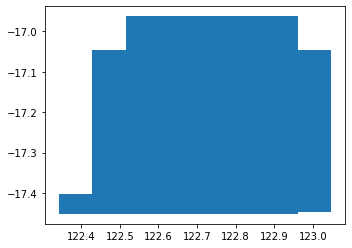

In [20]:
polygon_tiles_gpd.head(20000).plot()

In [21]:
polygon_tiles_gpd.to_file(os.path.join(output_folder,'output.gpkg'), driver="GPKG")    

In [20]:
tile_polygon_list[1]

{'geometry': <shapely.geometry.polygon.Polygon at 0x7f03e6c41880>,
 'intersect': {'/mnt/2TB Working 2/Projects/Ranglands ML/La grange test area/Test Vivid tiles/VIVID_Landgate_20190910_112301332230.tif'},
 'row': 0,
 'col': 415}

In [21]:
# make a list of which tiles are within which geotiffs
# loop over each geotiff
# for geo_tiff in tqdm(geo_tiff_list):
def intersector(geo_tiff):
    tiles_inside_geo_tiff = []
#     loop over each tile and check if the geotiff is the the intersect list
    for tile in tile_polygon_list:
        if geo_tiff in tile['intersect']:
#             we count this so we know if the tile will be incomplete or not
            incomplete = len(tile['intersect'])>1
#             build dict with geom the current row and col for naming
            tiles_inside_geo_tiff.append({'geometry':tile['geometry'],'row':tile['row'],'col':tile['col'],'incomplete':incomplete})
    return([geo_tiff,tiles_inside_geo_tiff])  

In [22]:
with Pool(12) as pool:
    geo_tiff_with_tiles = list(tqdm(pool.imap(intersector, geo_tiff_list), total=len(geo_tiff_list)))


  0%|          | 0/342 [00:00<?, ?it/s]

In [23]:
# loop over each geotiff
# for geotiff in tqdm(geo_tiff_with_tiles):
def cut_tiles(geotiff):
#     grab path to to file and open it
    geotiff_open = gdal.Open(geotiff[0])
#     grab the filename and strip the extention
    geo_tiff_filename = os.path.basename(geotiff[0]).replace(input_file_ext,'')
    incomplete_tile_list = []
    for tile in geotiff[1]:
        time_geometry = tile['geometry']
#         shapely bounds returns "minx, miny, maxx, maxy" but we need minx, maxy, maxx, miny
        top = list(time_geometry.bounds)[3]
        bottom = list(time_geometry.bounds)[1]
        left = list(time_geometry.bounds)[0]
        right =list(time_geometry.bounds)[2]
        
#         make row folder path
        output_row_folder = os.path.join(output_folder,str(tile['row']))
#       make row folder if nessasary
        Path(output_row_folder).mkdir(parents=True, exist_ok=True)
        export_file_name = str(tile['row'])+'_'+str(tile['col'])+'.tif'
        
#         check if tile is incomplete if so append the getiff name so that it is unique
        if tile['incomplete']:
            append_name = '-'+geo_tiff_filename+'_incomplete.tif'
            export_file_name = export_file_name.replace('.tif',append_name)
#             add tile to list so we dont need to refind them to compile incomplete tiles
            export_file_path = os.path.join(output_row_folder,export_file_name)
            incomplete_tile_list.append(export_file_path)
        else:
            export_file_path = os.path.join(output_row_folder,export_file_name)
        
#         check if already done
        if not os.path.isfile(export_file_path):

    #     clip the data
    #         make a string of tile dims to pass as a command line arg, this is ugly, would like a better option
            tile_clip_string = str(left) +' '+str(top) +' '+str(right) +' '+str(bottom)

            translate_options = gdal.TranslateOptions(gdal.ParseCommandLine("-projwin "+tile_clip_string)
                                                     ,creationOptions=['COMPRESS='+output_compression])

            tile_clip = gdal.Translate(export_file_path, geotiff_open, options = translate_options)
    #     close the tile
            tile_clip = None
    #         break
    return incomplete_tile_list

    

In [26]:
pool = Pool()
with pool:
    incomplete_tile_list = list(tqdm(pool.imap(cut_tiles,geo_tiff_with_tiles), total=len(geo_tiff_with_tiles)))

  0%|          | 0/342 [00:00<?, ?it/s]

In [28]:
#  the pool above returns all the incomplete tiles as a list of list, we need a flat list
flat_incomplete_tile_list = [item for sublist in incomplete_tile_list for item in sublist]
print(len(flat_incomplete_tile_list),'incomplete tiles')

33243 incomplete tiles


In [30]:
incomplete_tile_file_names = []
# from the flat list make a new list with just rows and cols to filter by
for incomplete_tile in flat_incomplete_tile_list:
    incomplete_tile_file_names.append(os.path.basename(incomplete_tile).split('-')[0])

In [31]:
# make a new datframe with paths and row/cols
incomplete_tile_df = pd.DataFrame(
    {'incomplete_tiles': flat_incomplete_tile_list,
     'row_col': incomplete_tile_file_names
    })

In [32]:
# handy gdal tool to merge files
def merge_tiles(merge_imgs, output_path):
    merge_command = ['gdal_merge.py', '-o', output_path, '-co','COMPRESS='+output_compression]
    for name in merge_imgs:
        merge_command.append(name)
    subprocess.run(merge_command)

In [33]:
def join_incomplete_tile(unique_tiles):
# for unique_tiles in incomplete_tile_df.row_col.unique():
#     filter the datframe down to only onw row and col
    gapminder_2002 = incomplete_tile_df[incomplete_tile_df['row_col']==unique_tiles]
#     get paths as list
    combine_these = gapminder_2002['incomplete_tiles'].tolist()
#     get export name by removing the geotiff names from end
    export_file_name = os.path.basename(combine_these[0]).split('-')[0]+'.tif'
#     grab the folder from the first tile
    export_dir_path = os.path.dirname(combine_these[0])
#     biuld full export path
    export_full_path = os.path.join(export_dir_path,export_file_name)
#     use gdal gdal_merge.py to merge the tiles
    merge_tiles(combine_these,export_full_path)
#     remove the incomplete tiles and msk files
    for incomplete_tile in combine_these:
        try:
            os.remove(incomplete_tile)
        except:
            print('could not remove')
        try:
            os.remove(incomplete_tile+'.msk')
        except:
            print('could not remove')
#     break
    

In [34]:
unique_tiles_list = incomplete_tile_df.row_col.unique()
pool = Pool()
with pool:
    incomplete_tile_list = list(tqdm(pool.imap(join_incomplete_tile,unique_tiles_list), total=len(unique_tiles_list)))

  0%|          | 0/16231 [00:00<?, ?it/s]